In [1]:
from config_file import data_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os

In [2]:
df = pd.read_csv(os.path.join(data_path, "artists_sessions", '0AD4odMWVQ2wUSlgxOB5Rl.csv'))

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df.head()

,timestamp,id_artist
0,2020-10-22 07:41:37.800229,0AD4odMWVQ2wUSlgxOB5Rl
1,2020-11-02 21:03:23.228205,0AD4odMWVQ2wUSlgxOB5Rl
2,2021-05-18 19:03:33.345066,0AD4odMWVQ2wUSlgxOB5Rl
3,2021-08-28 07:30:50.666227,0AD4odMWVQ2wUSlgxOB5Rl
4,2022-06-03 16:06:58.763342,0AD4odMWVQ2wUSlgxOB5Rl


In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
df.drop(["id_artist"], axis=1, inplace=True)
df["count"] = 1
df.head()

,count
timestamp,
2020-10-22 07:41:37.800229,1
2020-11-02 21:03:23.228205,1
2021-05-18 19:03:33.345066,1
2021-08-28 07:30:50.666227,1
2022-06-03 16:06:58.763342,1


In [6]:
df_resampled =df.resample("M").sum()

(            count
 timestamp        
 2019-07-31      1
 2019-08-31      8
 2019-09-30     18
 2019-10-31     24
 2019-11-30     32,
 (53, 1),
 <Axes: xlabel='timestamp'>)

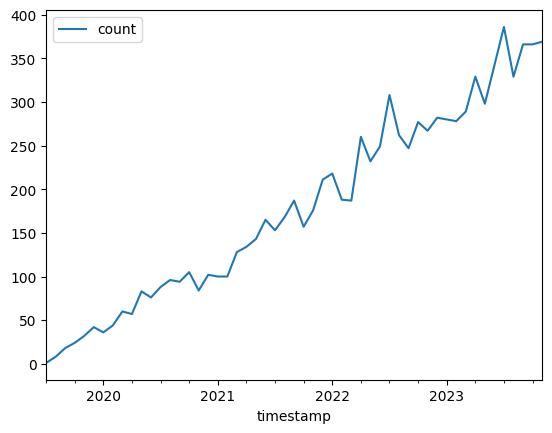

In [27]:
df_resampled.head(), df_resampled.shape, df_resampled.plot()

In [9]:
df_resampled.drop(df_resampled.tail(1).index, inplace=True)

<Axes: xlabel='timestamp'>

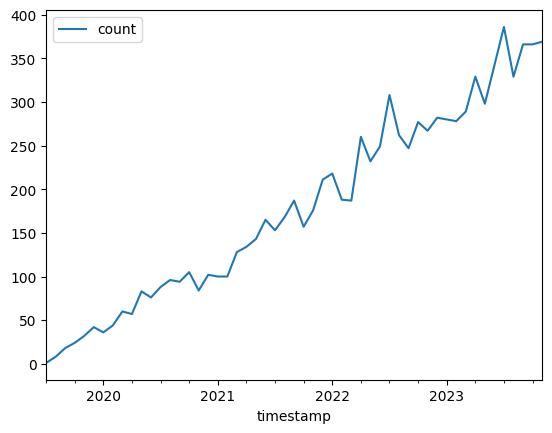

In [10]:
df_resampled.plot()

In [34]:
df_resampled_2 = df_resampled.copy()
print(df_resampled_2.head())
df_resampled_2["count"].values

            count
timestamp        
2019-07-31      1
2019-08-31      8
2019-09-30     18
2019-10-31     24
2019-11-30     32


array([  1,   8,  18,  24,  32,  42,  36,  44,  60,  57,  83,  76,  88,
        96,  94, 105,  84, 102, 100, 100, 128, 134, 143, 165, 153, 168,
       187, 157, 176, 211, 218, 188, 187, 260, 232, 249, 308, 262, 247,
       277, 267, 282, 280, 278, 289, 329, 298, 342, 386, 329, 366, 366,
       369])

In [35]:
train = df_resampled['count'].values[:len(df_resampled)-8]
test = df_resampled['count'].values[len(df_resampled)-8:]

sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima.fit(disp=False)
sarima_fit.aic

/media/data/coding/ium/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


296.77845249329414

In [36]:
def dummy_model(train, periods: int):
    dummy_pred = np.zeros(periods)
    for i in range(periods):
        if i == 0:
            dummy_pred[i] = train[- (periods) + i:].mean()
        else:
            dummy_pred[i] = train[- (periods) + i:].mean() * (periods - i) / periods + dummy_pred[:i].mean() * i / periods
    return dummy_pred

[272.75       274.09375    277.48046875 277.54052734 278.85809326
 278.46535492 278.27352428 278.30771482]


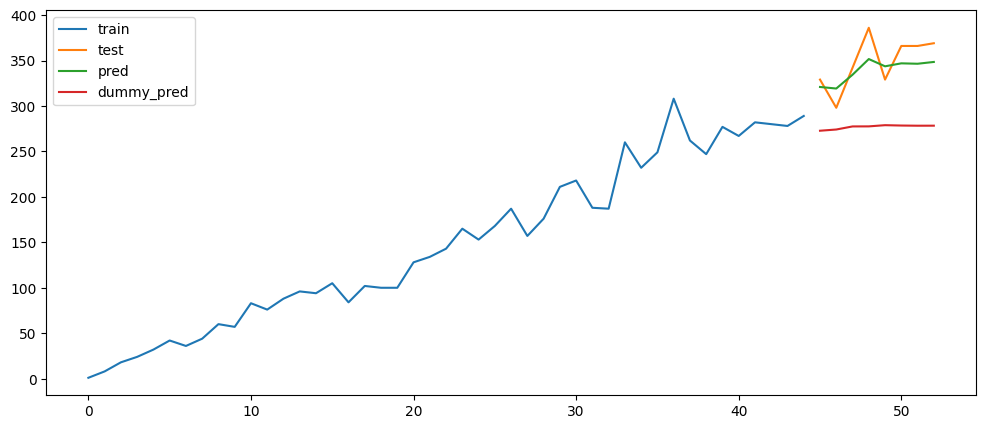

In [38]:
pred = sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
dummy_pred = dummy_model(train, len(test))
print(dummy_pred)

plt.figure(figsize=(12, 5))
plt.plot(train, label='train')
plt.plot([None] * len(train) + list(test), label='test')
plt.plot([None] * len(train) + list(pred), label='pred')
plt.plot([None] * len(train) + list(dummy_pred), label='dummy_pred')
# plt.plot([None] * len(train) + list(dummy_pred), label='dummy_pred')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, pred))
dummy_rmse = sqrt(mean_squared_error(test, dummy_pred))
print(rmse, dummy_rmse)

19.81734429416413 75.63014316730688
